In [ ]:
# REGRESSION TASK 0: SETUP + LOAD DATASET


import pandas as pd
import numpy as np

# ML + Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# train_test_split: splits data into train & test
# KFold: cross-validation splitting method
# GridSearchCV: tries multiple hyperparameters automatically

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Pipeline: for chaining steps
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# StandardScaler: normalize numeric columns (mean=0, std=1)
# OneHotEncoder: convert categories (like “City”) into dummy columns

from sklearn.impute import SimpleImputer
# simpleImputer : to fill missing values

# Models
from sklearn.linear_model import Ridge # to reduce overfitting
from sklearn.ensemble import RandomForestRegressor # averaged fo many decision trees
from sklearn.neural_network import MLPRegressor #neural network


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# MAE: average absolute error
# MSE/RMSE: penalizes big errors more; RMSE = sqrt(MSE)
# R²: goodness of fit
# Plots


import matplotlib.pyplot as plt

# -------- LOAD DATA --------
df = pd.read_csv("Fuelstations.csv")   # <-- IF PATH DIFFERENT, CHANGE THIS

print("SHAPE (rows, cols):", df.shape)
print("\nCOLUMNS:\n", df.columns.tolist())
df.head()


SHAPE (rows, cols): (20329, 38)

COLUMNS:
 ['Fuel Type Code', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State', 'ZIP', 'Plus4', 'Station Phone', 'Status Code', 'Expected Date', 'Groups With Access Code', 'Access Days Time', 'Cards Accepted', 'BD Blends', 'NG Fill Type Code', 'NG PSI', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network', 'EV Network Web', 'Geocode Status', 'Latitude', 'Longitude', 'Date Last Confirmed', 'ID', 'Updated At', 'Owner Type Code', 'Federal Agency ID', 'Federal Agency Name', 'Open Date', 'Hydrogen Status Link', 'NG Vehicle Class', 'LPG Primary', 'E85 Blender Pump', 'EV Connector Types']


,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,Updated At,Owner Type Code,Federal Agency ID,Federal Agency Name,Open Date,Hydrogen Status Link,NG Vehicle Class,LPG Primary,E85 Blender Pump,EV Connector Types
0,LPG,Irish Propane,70 Katherine St,At Bailey and Clinton,Buffalo,NY,14210,NaN,716-852-3335,E,...,2015-04-03 16:57:34 UTC,P,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1,ELEC,Latitudes,2401 Highway 528,NaN,Rio Rancho,NM,87124,NaN,505-369-7777,E,...,2015-01-06 17:43:46 UTC,P,NaN,NaN,2012-08-01,NaN,NaN,NaN,NaN,J1772
2,ELEC,American Bush - Solar Canopy,2630 S 300 W,Located across from Tire World,Salt Lake City,UT,84115,NaN,801-518-3529,E,...,2015-01-06 17:47:30 UTC,P,NaN,NaN,2011-12-01,NaN,NaN,NaN,NaN,J1772
3,ELEC,McDonald's #31850 - Flower Mound TX,3601 FM 407,NaN,Flower Mound,TX,75028,NaN,888-998-2546,E,...,2015-04-23 07:09:51 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J1772
4,ELEC,CITY OF SEATTLE,600 Pine St,NaN,Seattle,WA,98101,NaN,888-758-4389,E,...,2015-04-23 07:54:36 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J1772


In [ ]:
# REGRESSION TASK 1A: CHOOSE TARGET + BASIC CHECKS
# Target (y): EV DC Fast Count

target_col = "EV DC Fast Count"   # this is Target Variable

df = df.copy()
df[target_col] = pd.to_numeric(df[target_col], errors="coerce") #if it has bad text then it converts to Nan
df = df.dropna(subset=[target_col]) #removes missing targets

print("AFTER DROPPING MISSING TARGET -> SHAPE:", df.shape)
print("TARGET SUMMARY:")
print(df[target_col].describe()) # for mean, std, min/max


AFTER DROPPING MISSING TARGET -> SHAPE: (933, 38)
TARGET SUMMARY:
count    933.000000
mean       2.234727
std        2.151852
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       12.000000
Name: EV DC Fast Count, dtype: float64


In [ ]:
# REGRESSION TASK 1B: DATE CLEANING (IF PRESENT)
# Converting date columns into year/month/day features

date_cols = ["Expected Date", "Date Last Confirmed", "Updated At", "Open Date"]

for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)  # converting string into datetime forat  , utc=true avoids timezone issue
        # turning data into useful numeric features.
        df[c + "_year"] = df[c].dt.year
        df[c + "_month"] = df[c].dt.month
        df[c + "_day"] = df[c].dt.day

df = df.drop(columns=[c for c in date_cols if c in df.columns], errors="ignore") #Droping original date columns because model can't use raw datetime easily

print("DATE FEATURES ADDED. NEW SHAPE:", df.shape)


DATE FEATURES ADDED. NEW SHAPE: (933, 46)


In [ ]:
# REGRESSION TASK 1C: MISSING VALUES + DATA TYPES

print("\nINFO:")
df.info()

print("\nMISSING VALUES (TOP 20):")
print(df.isna().sum().sort_values(ascending=False).head(20)) # printing top 20 columns with most missing values.

print("\nNUMERICAL SUMMARY:")
display(df.select_dtypes(include="number").describe()) #Stats only for numeric columns.



INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 933 entries, 23 to 20257
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Fuel Type Code             933 non-null    object 
 1   Station Name               933 non-null    object 
 2   Street Address             933 non-null    object 
 3   Intersection Directions    183 non-null    object 
 4   City                       933 non-null    object 
 5   State                      933 non-null    object 
 6   ZIP                        933 non-null    int64  
 7   Plus4                      0 non-null      float64
 8   Station Phone              885 non-null    object 
 9   Status Code                933 non-null    object 
 10  Groups With Access Code    933 non-null    object 
 11  Access Days Time           883 non-null    object 
 12  Cards Accepted             6 non-null      object 
 13  BD Blends                  0 non-null      ob

,ZIP,Plus4,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,ID,Federal Agency ID,Expected Date_year,...,Expected Date_day,Date Last Confirmed_year,Date Last Confirmed_month,Date Last Confirmed_day,Updated At_year,Updated At_month,Updated At_day,Open Date_year,Open Date_month,Open Date_day
count,933.000000,0.0,82.000000,459.000000,933.000000,933.000000,933.000000,933.000000,3.000000,60.000000,...,60.000000,927.000000,927.000000,927.000000,933.0,933.000000,933.000000,598.000000,598.000000,598.000000
mean,64614.111468,NaN,1.646341,1.631808,2.234727,37.670527,-101.432183,57726.124330,15.333333,2014.883333,...,24.766667,2014.989213,2.241640,10.934196,2015.0,3.116827,16.202572,2013.245819,5.677258,12.143813
std,32265.819189,NaN,2.621713,1.980679,2.151852,5.373344,20.187593,8480.571913,1.154701,0.372425,...,9.453484,0.146567,1.510179,8.159386,0.0,1.190208,7.485803,1.311503,3.805293,10.333925
min,1003.000000,NaN,1.000000,1.000000,1.000000,19.609150,-159.440053,33555.000000,14.000000,2013.000000,...,1.000000,2013.000000,1.000000,3.000000,2015.0,1.000000,3.000000,2008.000000,1.000000,1.000000
25%,32750.000000,NaN,1.000000,1.000000,1.000000,33.867235,-121.176805,51253.000000,15.000000,2015.000000,...,15.000000,2015.000000,1.000000,6.000000,2015.0,2.000000,10.000000,2012.000000,2.250000,1.000000
50%,77388.000000,NaN,1.000000,1.000000,1.000000,37.820419,-99.319142,61677.000000,16.000000,2015.000000,...,30.000000,2015.000000,1.000000,6.000000,2015.0,4.000000,20.000000,2014.000000,5.000000,15.000000
75%,94043.000000,NaN,1.000000,1.000000,2.000000,41.579190,-83.498797,64650.000000,16.000000,2015.000000,...,30.000000,2015.000000,4.000000,23.000000,2015.0,4.000000,23.000000,2014.000000,10.000000,17.000000
max,99169.000000,NaN,18.000000,28.000000,12.000000,48.755809,-5.170103,66819.000000,16.000000,2015.000000,...,31.000000,2015.000000,12.000000,31.000000,2015.0,4.000000,25.000000,2015.000000,12.000000,31.000000


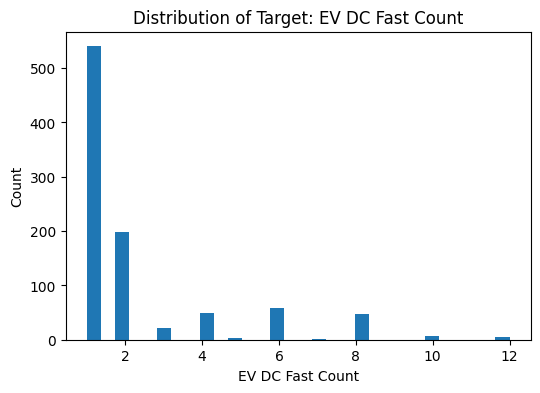

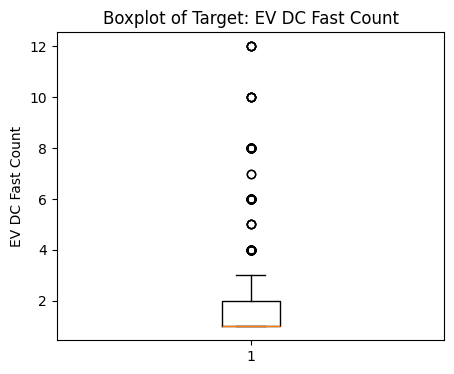

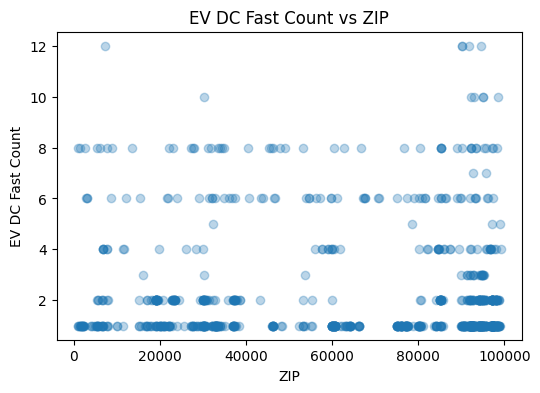

In [ ]:
# REGRESSION TASK 1D: EDA VISUALS

# Target distribution
plt.figure(figsize=(6,4))
plt.hist(df[target_col].dropna(), bins=30)
plt.title(f"Distribution of Target: {target_col}")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.show()

# Boxplot to see outliers
plt.figure(figsize=(5,4))
plt.boxplot(df[target_col].dropna(), vert=True)
plt.title(f"Boxplot of Target: {target_col}")
plt.ylabel(target_col)
plt.show()


num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols = [c for c in num_cols if c != target_col]

if len(num_cols) > 0:
    first_num = num_cols[0]
    plt.figure(figsize=(6,4))
    plt.scatter(df[first_num], df[target_col], alpha=0.3)
    plt.title(f"{target_col} vs {first_num}")
    plt.xlabel(first_num)
    plt.ylabel(target_col)
    plt.show()


In [ ]:
# REGRESSION TASK 2: NEURAL NETWORK (MLPRegressor)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# SPLITING X/y
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

all_missing_cols = [c for c in X.columns if X[c].isna().all()] #droping missing colums
X = X.drop(columns=all_missing_cols, errors="ignore")

X_train, X_test, y_train, y_test = train_test_split( #train and split
    X, y, test_size=0.2, random_state=42
)

numeric_features = X_train.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","bool","category"]).columns.tolist()

print("NUMERIC COLS:", len(numeric_features))
print("CATEGORICAL COLS:", len(categorical_features))

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=30))  # Colab-friendly
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# Neural Network model
nn_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=400,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=15
    ))
])

# Fit
nn_model.fit(X_train, y_train)

# Predict
pred_nn = nn_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, pred_nn)
rmse = np.sqrt(mean_squared_error(y_test, pred_nn))
r2 = r2_score(y_test, pred_nn)

print("\nNEURAL NETWORK RESULTS")
print("MAE :", mae)
print("RMSE:", rmse)
print("R^2 :", r2)


NUMERIC COLS: 19
CATEGORICAL COLS: 18

NEURAL NETWORK RESULTS
MAE : 0.5383798851077904
RMSE: 0.8263827164474775
R^2 : 0.822586077447226


In [ ]:
# REGRESSION TASK 3: TWO CLASSICAL MODELS
# Models: Ridge (Linear) + RandomForest

def eval_regression(name, model, X_test, y_test):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    print(f"\n{name}")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R^2 :", r2)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

# model Ridge
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(random_state=42))
])

# omdel Random Forest
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

ridge_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

res_ridge = eval_regression("Ridge Regression", ridge_model, X_test, y_test)
res_rf    = eval_regression("Random Forest", rf_model, X_test, y_test)

results_task3 = pd.DataFrame([res_ridge, res_rf])
results_task3
#evaluating and storing in dataframe


Ridge Regression
MAE : 0.4892178032191821
RMSE: 0.7637839144499476
R^2 : 0.8484463980481276

Random Forest
MAE : 0.33085561497326205
RMSE: 0.7214894724273733
R^2 : 0.8647662023416838


,Model,MAE,RMSE,R2
0,Ridge Regression,0.489218,0.763784,0.848446
1,Random Forest,0.330856,0.721489,0.864766


In [ ]:
# REGRESSION TASK 4: HYPERPARAMETER TUNING (GridSearchCV)
# Cross-validation: KFold (5 folds)
# Scoring: negative RMSE (sklearn style)

cv = KFold(n_splits=5, shuffle=True, random_state=42) #spliting the training data into 5 parts

# Ridge tuning
ridge_params = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 50.0] #alpha controls regularization strength.
}

ridge_grid = GridSearchCV(
    estimator=ridge_model,
    param_grid=ridge_params,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("BEST RIDGE PARAMS:", ridge_grid.best_params_)
print("BEST RIDGE CV SCORE (neg RMSE):", ridge_grid.best_score_)

# Random Forest tuning
rf_params = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("\nBEST RF PARAMS:", rf_grid.best_params_)
print("BEST RF CV SCORE (neg RMSE):", rf_grid.best_score_)




BEST RIDGE PARAMS: {'model__alpha': 1.0}
BEST RIDGE CV SCORE (neg RMSE): -1.017720412906041

BEST RF PARAMS: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
BEST RF CV SCORE (neg RMSE): -0.9385993748542278


In [ ]:
# REGRESSION TASK 5: FEATURE SELECTION (SelectKBest - Filter Method)
# Applies feature selection AFTER preprocessing
# Prints: selected features + scores + model performance

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# SETTINGS
k_best = 30  # number of best features to select

# BUILD MODELS WITH FEATURE SELECTION
ridge_fs_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=f_regression, k=k_best)),
    ("model", Ridge(alpha=ridge_grid.best_params_["model__alpha"], random_state=42))
])

rf_fs_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=f_regression, k=k_best)),
    ("model", RandomForestRegressor(
        random_state=42,
        n_estimators=rf_grid.best_params_["model__n_estimators"],
        max_depth=rf_grid.best_params_["model__max_depth"],
        min_samples_split=rf_grid.best_params_["model__min_samples_split"],
        min_samples_leaf=rf_grid.best_params_["model__min_samples_leaf"],
        n_jobs=-1
    ))
])

# FITTING BOTH
ridge_fs_model.fit(X_train, y_train)
rf_fs_model.fit(X_train, y_train)

print("Models fitted with SelectKBest feature selection.")

# SHOW SELECTED FEATURES + SCORES
# Get feature names after preprocess (includes one-hot encoded columns)
feature_names = ridge_fs_model.named_steps["preprocess"].get_feature_names_out()

# Ridge selected
ridge_selector = ridge_fs_model.named_steps["select"]
ridge_mask = ridge_selector.get_support()
ridge_selected_features = feature_names[ridge_mask]
ridge_scores = ridge_selector.scores_[ridge_mask]

ridge_feat_table = pd.DataFrame({
    "Feature": ridge_selected_features,
    "F_score": ridge_scores
}).sort_values("F_score", ascending=False).reset_index(drop=True)

print("\n==============================")
print(f"RIDGE - TOP {len(ridge_selected_features)} SELECTED FEATURES (SelectKBest)")
print("==============================")
print(ridge_feat_table.head(30))

# RF selected (same SelectKBest method, so selected features should match Ridge)
rf_selector = rf_fs_model.named_steps["select"]
rf_mask = rf_selector.get_support()
rf_selected_features = feature_names[rf_mask]
rf_scores = rf_selector.scores_[rf_mask]

rf_feat_table = pd.DataFrame({
    "Feature": rf_selected_features,
    "F_score": rf_scores
}).sort_values("F_score", ascending=False).reset_index(drop=True)

print("\n==============================")
print(f"RANDOM FOREST - TOP {len(rf_selected_features)} SELECTED FEATURES (SelectKBest)")
print("==============================")
print(rf_feat_table.head(30))


# EVALUATE BOTH MODELS (TEST SET)
def eval_reg(name, model, X_test, y_test):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    print("\n" + "="*35)
    print(name)
    print("="*35)
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R^2 :", r2)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

ridge_res = eval_reg("RIDGE (Tuned + SelectKBest)", ridge_fs_model, X_test, y_test)
rf_res    = eval_reg("RANDOM FOREST (Tuned + SelectKBest)", rf_fs_model, X_test, y_test)

final_table = pd.DataFrame([ridge_res, rf_res])
print("\n==============================")
print("FINAL COMPARISON TABLE")
print("==============================")
print(final_table)



✅ Models fitted with SelectKBest feature selection.

RIDGE - TOP 30 SELECTED FEATURES (SelectKBest)
                                              Feature      F_score
0                       cat__EV Connector Types_TESLA  2221.329399
1                     cat__Station Phone_877-798-3752  2092.224113
2                               cat__EV Network_Tesla  2030.078151
3   cat__EV Network Web_http://www.teslamotors.com...  2030.078151
4   cat__Access Days Time_24 hours daily; for Tesl...  1829.427530
5                        cat__EV Network_eVgo Network   178.809234
6    cat__EV Network Web_https://www.evgonetwork.com/   178.809234
7   cat__Intersection Directions_One-way street ac...   169.120919
8     cat__Intersection Directions_infrequent_sklearn   169.120919
9                                  num__Open Date_day   156.274633
10                cat__Groups With Access Code_Public   138.512864
11                              num__Updated At_month    81.262784
12              cat__EV Conne

In [ ]:
# REGRESSION TASK 6: FINAL MODELS + COMPARISON TABLE

import pandas as pd

# MakING a clean copy of X_test
# REMOVING 100% missing columns
X_test_clean = X_test.copy()

all_missing_cols_test = [c for c in X_test_clean.columns if X_test_clean[c].isna().all()]
X_test_clean = X_test_clean.drop(columns=all_missing_cols_test, errors="ignore")

try:
    X_test_clean = X_test_clean.reindex(columns=X_train.columns, fill_value=np.nan)
except:
    pass

final_ridge = eval_regression(
    "FINAL Ridge (Tuned + Feature Selection)",
    ridge_fs_model,
    X_test_clean,
    y_test
)

final_rf = eval_regression(
    "FINAL RandomForest (Tuned + Feature Selection)",
    rf_fs_model,
    X_test_clean,
    y_test
)

final_table = pd.DataFrame([final_ridge, final_rf])
final_table



FINAL Ridge (Tuned + Feature Selection)
MAE : 0.5178050161957667
RMSE: 0.7837149973394472
R^2 : 0.8404335576074393

FINAL RandomForest (Tuned + Feature Selection)
MAE : 0.3793847575775218
RMSE: 0.8261472756911525
R^2 : 0.8226871553545074


,Model,MAE,RMSE,R2
0,FINAL Ridge (Tuned + Feature Selection),0.517805,0.783715,0.840434
1,FINAL RandomForest (Tuned + Feature Selection),0.379385,0.826147,0.822687
